In [105]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
#we need to load proper data sets
#all.csv contains all individual clusters
all_df = pd.read_csv('all.csv')

#my_e contains a list of clusters for which 
#I determined the energy using the developed approximation techniques
my_e = pd.read_csv('my_e.csv').drop(['Unnamed: 0','SCF_steps','magnetism',
                                     'time_of_calculation'],axis=1)

#clusters_phd.csv contains a bunch of clusters with precisely determined energy
#however, not all of the cases in this set were determined also by me
#the common part was included in the phd_common_part
phd = pd.read_csv('phd_common_part.csv').drop(['Unnamed: 0','SCF_steps','magnetism',
                                               'time_of_calculation'],axis=1)


### Data Extracting

In [39]:
#both phd and my_e do not contain any information that could be used by the model
#this information is in the all.csv file, so it must be extracted and assigned 
#to the appropriate rows in the mentioned data sets

def topology_to_list(imported_topology):
    topology = []
    for i in range(2,80,6):
        topology.append(imported_topology[i:i+2])        
    return topology

def extracting(df):
    #I want to load some information from all.csv
    
    #splitting "full_notation" column
    df = df.assign(number = df['full_notation'].apply(lambda x: x.split('_')[0]),
              joining_type = df['full_notation'].apply(lambda x: x.split('_')[1]),
              first_atom = df['full_notation'].apply(lambda x: x.split('_')[2]),
              second_atom = df['full_notation'].apply(lambda x: x.split('_')[3]),
            no_nickel = all_df['no_nickel'].apply(lambda x: x))
        
    df['no_nickel'], df['c_atom'],df['mass_center'],df['shortest_paths'] = None,None,None,None
    df['bonds'], df['conformation'], df['hydrogen'], df['topology'] = None, None, None, None
    df['type_of_first_atom'], df['type_of_second_atom'] = None,None
    df['energy_wth_h2'] = df['energy']
    
    for cluster in range(len(df)):
        for column in ['no_nickel','c_atom','mass_center','shortest_paths','conformation','bonds']:
            df[column].iloc[cluster] = all_df[column].loc[int(df['number'].iloc[cluster])]
        for column in ['topology']:
            df[column].iloc[cluster] = topology_to_list(all_df[column].loc[int(df['number'].iloc[cluster])])
        df['hydrogen'].iloc[cluster] = 1 if df['joining_type'].iloc[cluster] in ['MOCOM','MOCM_H_n_bond','MC'] else 0
        if df['joining_type'].iloc[cluster] in ['MOCOM','MOCMHnbond','MC']:
            df['energy_wth_h2'].iloc[cluster] += 3.344

    for cluster in range(len(df)):
        df['type_of_first_atom'].iloc[cluster] = df['topology'].iloc[cluster][int(df['first_atom'].iloc[cluster])]
        df['type_of_second_atom'].iloc[cluster] = df['topology'].iloc[cluster][int(df['second_atom'].iloc[cluster])]
    
    df = df.assign(ni_ncentre = df['shortest_paths'].apply(lambda x:x.split(',')[0][1:]),
              ni_centre = df['shortest_paths'].apply(lambda x:x.split(',')[1]),
               cu_ncentre = df['shortest_paths'].apply(lambda x:x.split(',')[2]),
                cu_centre = df['shortest_paths'].apply(lambda x:x.split(',')[3][:-1]),
                ni0 = df['conformation'].apply(lambda x: x.split(',')[0][1:]),
               ni8 = df['conformation'].apply(lambda x: x.split(',')[1]),
               ni17 = df['conformation'].apply(lambda x: x.split(',')[2]),
               ni25 = df['conformation'].apply(lambda x: x.split(',')[3]),
               ni33 = df['conformation'].apply(lambda x: x.split(',')[4]),
               ni42 = df['conformation'].apply(lambda x: x.split(',')[5]),
               ni50 = df['conformation'].apply(lambda x: x.split(',')[6][:-1]),
               nini = df['bonds'].apply(lambda x: x.split(',')[0][1:]),
               cucu = df['bonds'].apply(lambda x: x.split(',')[1]),
               nicu = df['bonds'].apply(lambda x: x.split(',')[2][:-1]))
    
    return df.drop(['shortest_paths','bonds','conformation','topology'],axis=1)
    
def energy_redu(df,column, hydrogen_correction=False,new_name='redu_energy'):
    #function that transcribe energy to reduce energy

    #first value is nickel energy, second is cooper
    if hydrogen_correction == False:
        monomet_cl_energy = {'MO':(-74.568295,-57.156901),
                                             'MOCOM':(-79.855113,-62.216739),
                                             'MOCMHnbond':(-79.004707,-61.301059),
                                             'MC':(-78.378661,-60.821898),
                                             'MOCM':(-75.478348,-57.428965)}
    #hydrogen corrections
    else:
        monomet_cl_energy = {'MO':(-74.568295,-57.156901),
                                             'MOCOM':(-79.855113+3.344,-62.216739+3.344),
                                             'MOCMHnbond':(-79.004707+3.344,-61.301059+3.344),
                                             'MC':(-78.378661+3.344,-60.821898+3.344),
                                             'MOCM':(-75.478348,-57.428965)}
    if column in df.columns and 'no_nickel' in df.columns and 'joining_type' in df.columns:
        print('Appriopiate columns are present in database')
        df[new_name] = None
        for i in range(len(df)):
            energy = df[column].iloc[i]
            nickel_part = monomet_cl_energy[df['joining_type'].iloc[i]][0]
            copper_part = monomet_cl_energy[df['joining_type'].iloc[i]][1]
            nickel = int(df['no_nickel'].iloc[i])           
            df[new_name].iloc[i] = (energy - (1/13)*(nickel*nickel_part + (13-nickel)*copper_part))
        return df
    else:
        print('Given database is missing at least one column')

def generating_full_db(df):
    final_df = energy_redu(extracting(df),'energy')
    final_df = energy_redu(final_df,'energy_wth_h2',hydrogen_correction=True,new_name='redu_energy_wth_h2')
    return final_df

### ML section

In [106]:
# thanks to above code I can generate good data sets by only one line

my_e = generating_full_db(my_e)
phd = generating_full_db(phd)
my_e

Appriopiate columns are present in database
Appriopiate columns are present in database
Appriopiate columns are present in database
Appriopiate columns are present in database


,full_notation,energy,number,joining_type,first_atom,second_atom,no_nickel,c_atom,mass_center,hydrogen,...,ni17,ni25,ni33,ni42,ni50,nini,cucu,nicu,redu_energy,redu_energy_wth_h2
0,58_MO_7_11,-65.233019,58,MO,7,11,6,1,0.04345,0,...,2,5,3,1,0,24,24,36,-0.04009,-0.04009
1,58_MOCOM_7_11,-70.411401,58,MOCOM,7,11,6,1,0.04345,1,...,2,5,3,1,0,24,24,36,-0.053874,-0.053874
2,59_MO_1_6,-65.574785,59,MO,1,6,6,1,0.03448,0,...,4,3,5,0,0,22,22,40,-0.381856,-0.381856
3,59_MO_4_1,-65.529727,59,MO,4,1,6,1,0.03448,0,...,4,3,5,0,0,22,22,40,-0.336798,-0.336798
4,59_MO_7_6,-65.504183,59,MO,7,6,6,1,0.03448,0,...,4,3,5,0,0,22,22,40,-0.311254,-0.311254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,141_MC_11_6,-70.261721,141,MC,11,6,8,0,0.01793,1,...,1,7,3,1,0,24,12,48,1.364339,1.364339
645,156_MC_5_4,-71.162286,156,MC,5,4,8,1,0.03631,1,...,0,0,10,0,1,34,10,40,0.463774,0.463774
646,190_MOCM_8_7,-73.355261,190,MOCM,8,7,12,1,0.01705,0,...,0,0,0,5,7,72,0,12,0.734673,0.734673
647,150_MOCMHnbond_5_10,-71.674709,150,MOCMHnbond,5,10,8,1,0.0315,0,...,1,2,6,3,0,34,10,40,0.520903,0.520903


### EDA

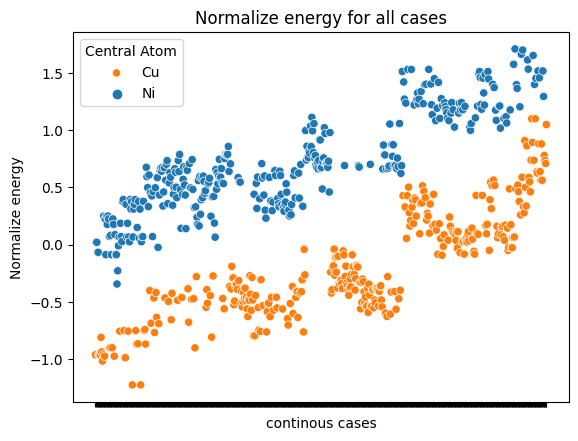

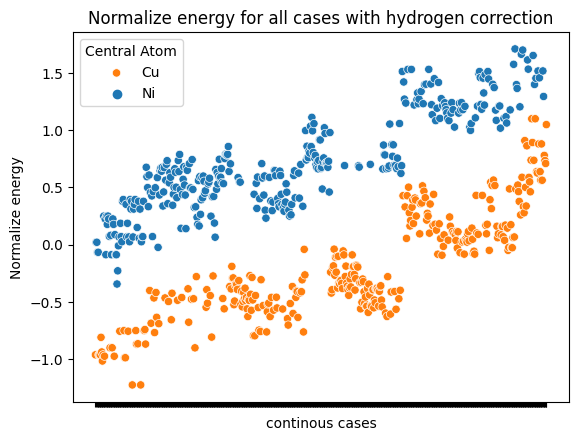

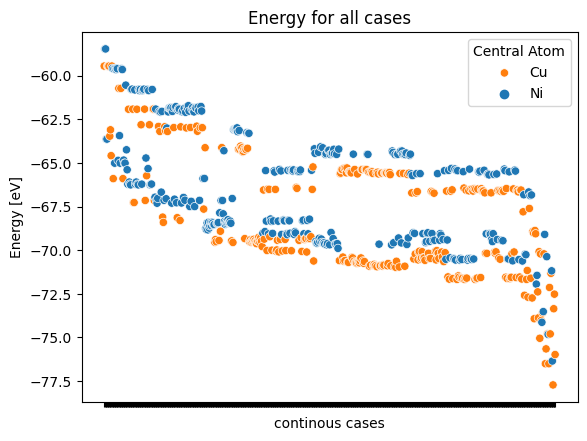

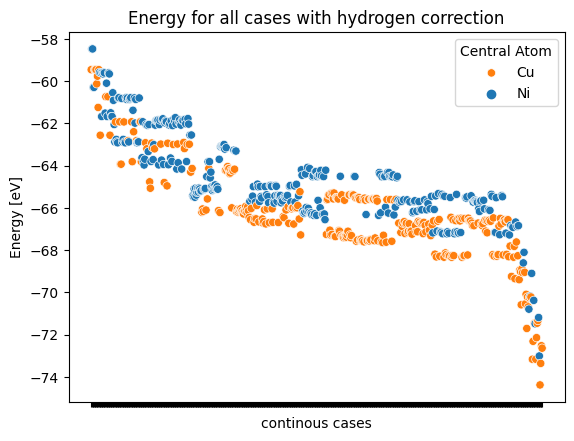

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

g1 = sns.scatterplot(data=my_e.sort_values(by='no_nickel'), x='full_notation',y="redu_energy", hue='c_atom')
g1.set(xlabel='continous cases', ylabel = 'Normalize energy', xticklabels=[], title = 'Normalize energy for all cases')
plt.legend(title='Central Atom', labels =['Cu','Ni'])
plt.show()

g2 = sns.scatterplot(data=my_e.sort_values(by='no_nickel'), x='full_notation',y="redu_energy_wth_h2", hue='c_atom')
g2.set(xlabel='continous cases', ylabel = 'Normalize energy', xticklabels=[], title = 'Normalize energy for all cases with hydrogen correction')
plt.legend(title='Central Atom', labels =['Cu','Ni'])
plt.show()

g3 = sns.scatterplot(data=my_e.sort_values(by='no_nickel'), x='full_notation',y="energy", hue='c_atom')
g3.set(xlabel='continous cases', ylabel = 'Energy [eV]', xticklabels=[], title = 'Energy for all cases')
plt.legend(title='Central Atom', labels =['Cu','Ni'])
plt.show()

g4 = sns.scatterplot(data=my_e.sort_values(by='no_nickel'), x='full_notation',y="energy_wth_h2", hue='c_atom')
g4.set(xlabel='continous cases', ylabel = 'Energy [eV]', xticklabels=[], title = 'Energy for all cases with hydrogen correction')
plt.legend(title='Central Atom', labels =['Cu','Ni'])
plt.show()

In [140]:
my_e = pd.DataFrame(data=my_e, columns = ['full_notation', 'energy','energy_wth_h2','redu_energy',
        'redu_energy_wth_h2', 'number', 'joining_type', 'first_atom',
       'second_atom', 'no_nickel', 'mass_center', 'hydrogen',        
       'ni_ncentre', 'ni_centre', 'cu_ncentre', 'cu_centre', 'ni0', 'ni8',
       'ni17', 'ni25', 'ni33', 'ni42', 'ni50', 'nini', 'cucu', 'nicu','c_atom',
        'type_of_first_atom', 'type_of_second_atom',                                          
        ])
my_e


,full_notation,energy,energy_wth_h2,redu_energy,redu_energy_wth_h2,number,joining_type,first_atom,second_atom,no_nickel,...,ni25,ni33,ni42,ni50,nini,cucu,nicu,c_atom,type_of_first_atom,type_of_second_atom
0,58_MO_7_11,-65.233019,-65.233019,-0.04009,-0.04009,58,MO,7,11,6,...,5,3,1,0,24,24,36,1,Cu,Cu
1,58_MOCOM_7_11,-70.411401,-67.067401,-0.053874,-0.053874,58,MOCOM,7,11,6,...,5,3,1,0,24,24,36,1,Cu,Cu
2,59_MO_1_6,-65.574785,-65.574785,-0.381856,-0.381856,59,MO,1,6,6,...,3,5,0,0,22,22,40,1,Ni,Cu
3,59_MO_4_1,-65.529727,-65.529727,-0.336798,-0.336798,59,MO,4,1,6,...,3,5,0,0,22,22,40,1,Ni,Ni
4,59_MO_7_6,-65.504183,-65.504183,-0.311254,-0.311254,59,MO,7,6,6,...,3,5,0,0,22,22,40,1,Ni,Cu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,141_MC_11_6,-70.261721,-66.917721,1.364339,1.364339,141,MC,11,6,8,...,7,3,1,0,24,12,48,0,Ni,Ni
645,156_MC_5_4,-71.162286,-67.818286,0.463774,0.463774,156,MC,5,4,8,...,0,10,0,1,34,10,40,1,Ni,Cu
646,190_MOCM_8_7,-73.355261,-73.355261,0.734673,0.734673,190,MOCM,8,7,12,...,0,0,5,7,72,0,12,1,Ni,Ni
647,150_MOCMHnbond_5_10,-71.674709,-68.330709,0.520903,0.520903,150,MOCMHnbond,5,10,8,...,2,6,3,0,34,10,40,1,Cu,Cu


<Axes: >

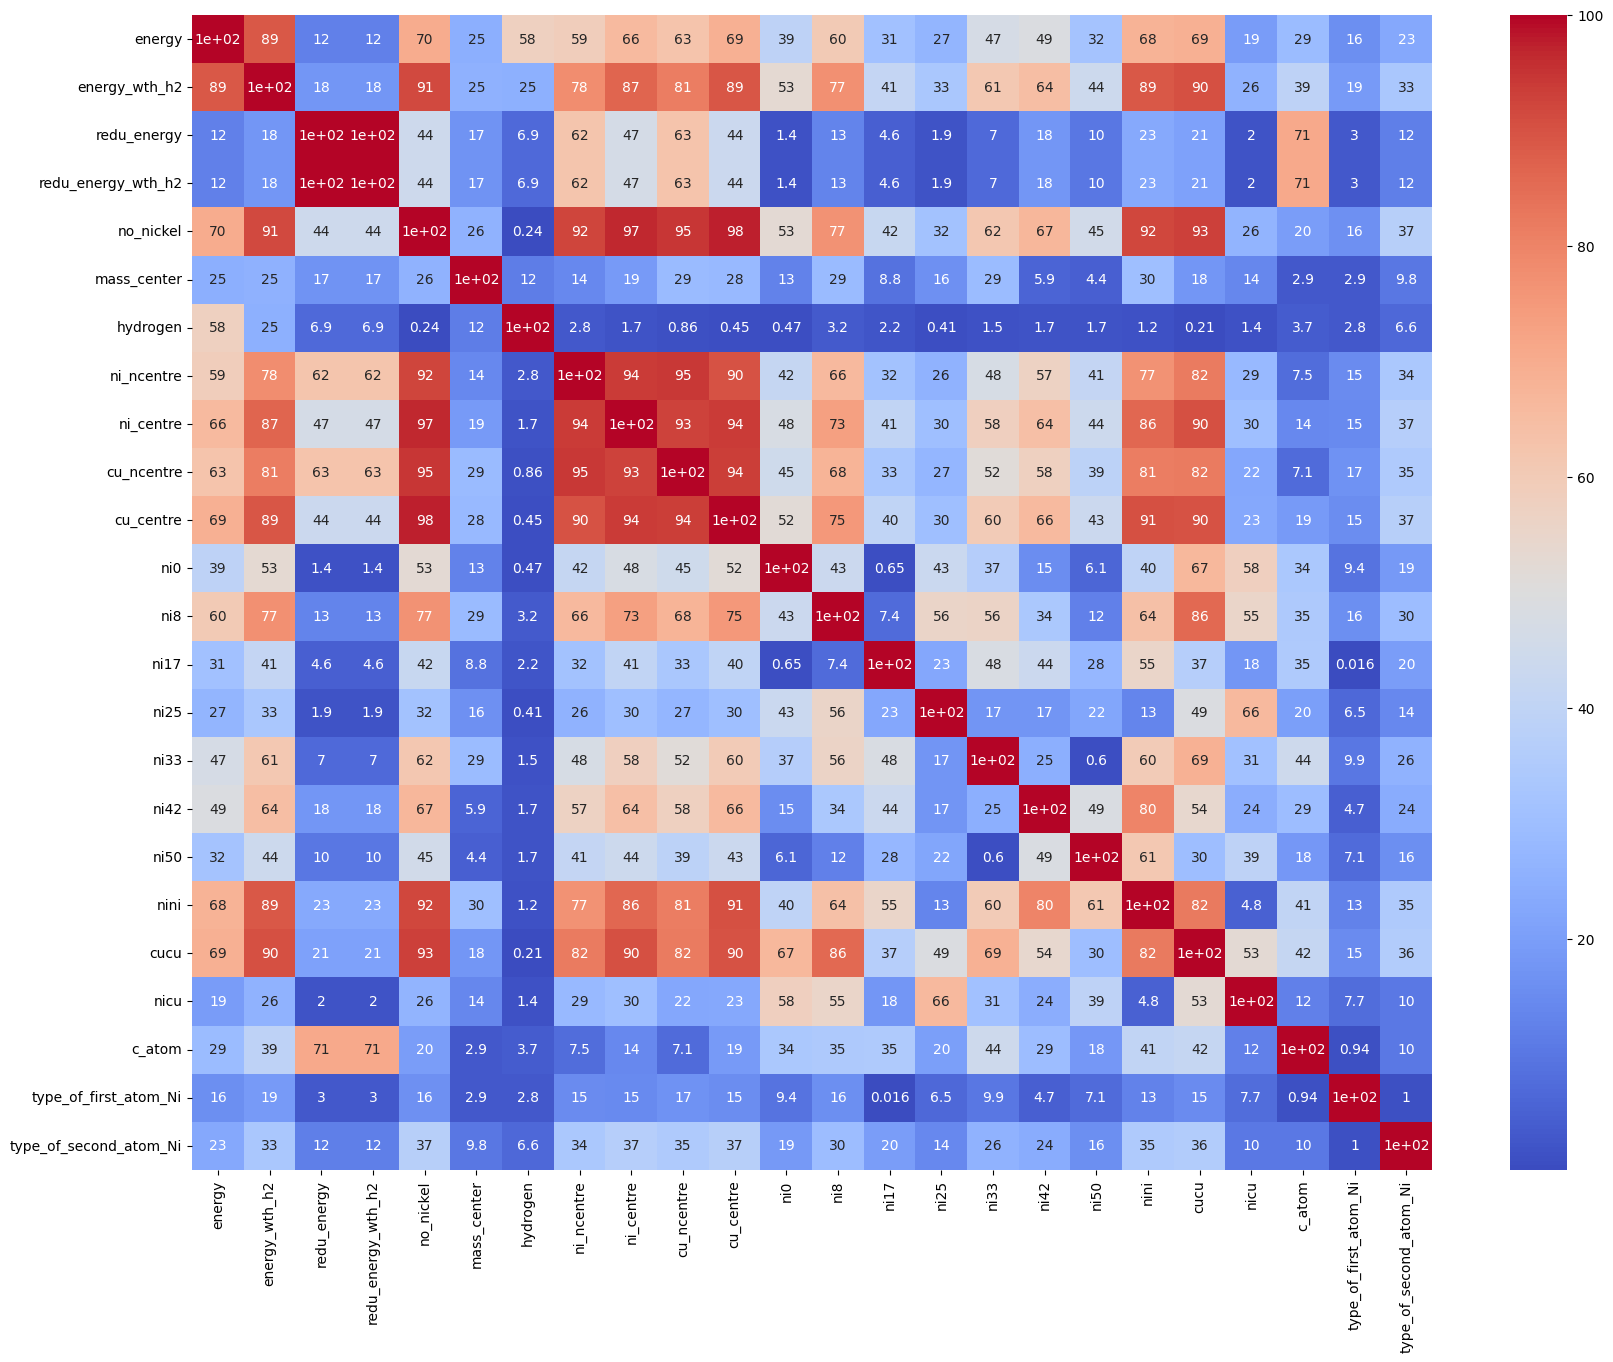

In [141]:
X = pd.get_dummies(data = my_e, columns = ['type_of_first_atom','type_of_second_atom'], drop_first=True)
plt.subplots(figsize=(20,15))
sns.heatmap(((X.drop(['full_notation','joining_type',
                      'number','first_atom','second_atom'
                     ],axis=1).corr()*100)**2)**0.5,annot=True, cmap='coolwarm')

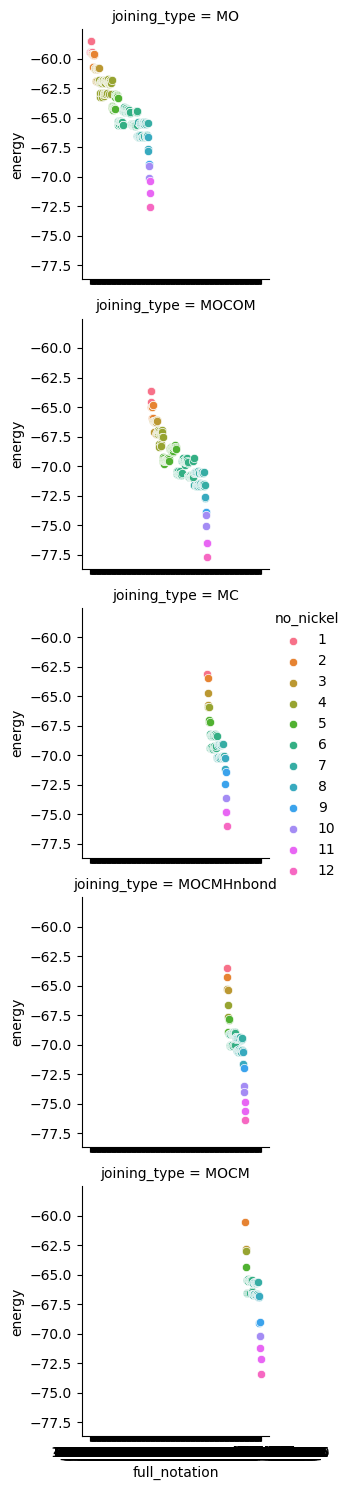

In [65]:
g = sns.FacetGrid(my_e,row='joining_type', hue='no_nickel')
g.map(sns.scatterplot, "full_notation","energy")
g.add_legend()